# Preparation

In [1]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

import os
import sys
from datetime import datetime
import time
from pprint import pprint
from contextlib import redirect_stdout
import re
import io

# import itertools
from natsort import natsorted
from icecream import ic
# import logging  # https://gist.github.com/joshbode/58fac7ababc700f51e2a9ecdebe563ad

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

In [3]:
# import imgaug as ia
# from imgaug import augmenters as iaa

In [4]:
# attention
am_I_using_colab = False

In [5]:
# if am_I_using_colab:
#     !pip install -U tensorflow-addons
    
# import tensorflow_addons as tfa
# import tqdm

In [6]:
# plt.ioff()  # interactive mode off
# plt.ion()  # interactive mode on

# %pylab inline

np.random.seed(1728)
# ia.random.seed(1728)

In [7]:
if am_I_using_colab:
    ###
    from google.colab import drive
    drive.mount('/content/drive')

    print(os.getcwd())
    print(os.listdir())

    ###
    temp_dir = '/content/temp'
    try:
        os.mkdir(temp_dir)
    except:
        pass
    print(os.listdir(temp_dir))

    ###
    dataset_filepath = f'{temp_dir:s}/dataset_v1_test.7z'
    import gdown
    gdown.download(
        r'https://drive.google.com/uc?id=1PPZ7WgKVsPjvfkQN33IItxOIfm2RjOBY',
        output=dataset_filepath,
        quiet=False,
        )

    ###
    !pip install py7zr
    import py7zr
    with py7zr.SevenZipFile(dataset_filepath, 'r') as archive:
        archive.extractall(path="./dataset_v1_test")

    ###


In [8]:
import time

def mulai_hitung_waktu():
    global waktu_mulai
    waktu_mulai = time.time()

def cetak_lama_waktu(to='ms'):
    global waktu_mulai
    now = time.time()
    hasil_detik = abs(waktu_mulai - now)
    hasil_milidetik = hasil_detik * 1000
    
    menit = hasil_detik / 60
    detik = hasil_detik % 60
    
    
    if to == 's':
        waktu = f"{int(hasil_detik):3d}s"
    elif to == 'ms':
        waktu = f"{int(menit):3d}m:{int(detik):2d}s" # :{int(hasil_milidetik%1000):3d}ms
        
    print('-----\n(%.2f ms) == (%s)\n-----' % (hasil_milidetik, waktu))
    return waktu
    del waktu_mulai


# cara pakai
# ----------
mulai_hitung_waktu()  ###

time.sleep(150/1000)  # time-consuming computing here

cetak_lama_waktu('s')  ###

-----
(155.01 ms) == (  0s)
-----


'  0s'

In [9]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("Num GPUs Available: %d Physical GPUs, %d Logical GPU" % (len(gpus), len(logical_gpus)))
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

Num GPUs Available: 1 Physical GPUs, 1 Logical GPU


## Setup Directories

In [10]:
if am_I_using_colab:
    WORK_DIR = '/content'
    TRAIN_SET_PATH = f'{WORK_DIR}/dataset_v1'
    # TEST_SET_PATH = f''

    DRIVE_DIR = '/content/drive/MyDrive/MyNotebook/MySkripsi'
    CHECKPOINTS_DIR = f'{WORK_DIR}/checkpoints'
    FINAL_EPOCH_DIR = f'{WORK_DIR}/weights and models'

else:
    WORK_DIR = r'D:\Model testing'
    TRAIN_SET_PATH = r'D:\MaskTheFace\datasets\_temp\_v1'
    TEST_SET_PATH = r'D:\MaskTheFace\datasets\_temp\_v1 - test only'

WEIGHTS_AND_MODELS_DIR = fr'{WORK_DIR}\weights and models'
TEST_RESULTS_DIR = fr'{WORK_DIR}\results'

directories = [
    WEIGHTS_AND_MODELS_DIR,
    TEST_RESULTS_DIR
]

# Set working directory
os.chdir(WORK_DIR)

print('current work dir:')
print(os.getcwd())
print()
print('listdir WORK_DIR:')
print(len(os.listdir('./')))
pprint(natsorted(os.listdir('./')))

current work dir:
D:\Model testing

listdir WORK_DIR:
2
['results', 'weights and models']


In [11]:
print('listdir WEIGHTS_AND_MODELS_DIR:')
model_names = natsorted(os.listdir(WEIGHTS_AND_MODELS_DIR))

print(len(model_names))
pprint(model_names)

listdir WEIGHTS_AND_MODELS_DIR:
63
['lenet5_actual_32-16',
 'lenet5_actual_32-32',
 'lenet5_actual_32-64',
 'lenet5_actual_rm-32-16',
 'lenet5_actual_rm-32-32',
 'lenet5_actual_rm-32-64',
 'lenet5_actual_rm-64-16',
 'lenet5_actual_rm-64-32',
 'lenet5_actual_rm-64-64',
 'lenet5_actual_rm-96-16',
 'lenet5_actual_rm-96-32',
 'lenet5_actual_rm-96-64',
 'lenet5_actual_rm-128-16',
 'lenet5_actual_rm-128-32',
 'lenet5_actual_rm-128-64',
 'mobilenetv2_1.00_32-16-12',
 'mobilenetv2_1.00_32-16-fc12',
 'mobilenetv2_1.00_32-32-12',
 'mobilenetv2_1.00_32-32-fc12',
 'mobilenetv2_1.00_32-64-12',
 'mobilenetv2_1.00_32-64-fc12',
 'mobilenetv2_1.00_32-imagenet224-16-12',
 'mobilenetv2_1.00_32-imagenet224-16-fc12',
 'mobilenetv2_1.00_32-imagenet224-32-12',
 'mobilenetv2_1.00_32-imagenet224-32-fc12',
 'mobilenetv2_1.00_32-imagenet224-64-12',
 'mobilenetv2_1.00_32-imagenet224-64-fc12',
 'mobilenetv2_1.00_64-16-12',
 'mobilenetv2_1.00_64-16-fc12',
 'mobilenetv2_1.00_64-32-12',
 'mobilenetv2_1.00_64-32-fc12'

In [12]:
print('listdir TEST_RESULTS_DIR:')
print(len(os.listdir(TEST_RESULTS_DIR)))
pprint(natsorted(os.listdir(TEST_RESULTS_DIR)))

listdir TEST_RESULTS_DIR:
7
['lenet-5 versi asli (035).evaluate_turbo',
 'lenet-5 versi asli (035).predict_turbo',
 'lenet-5 versi asli.evaluate_turbo',
 'lenet-5 versi asli.predict_turbo',
 'lenet-5 versi modifikasi (035).evaluate_turbo',
 'lenet-5 versi modifikasi.evaluate_turbo',
 'lenet-5 versi modifikasi.predict_turbo']


In [13]:
names = os.listdir(TEST_SET_PATH)

length_dict = {}
for name in names:
    samples = f'{TEST_SET_PATH:s}/{name:s}'
    length_dict[name] = len(os.listdir(samples))

n_min = min(length_dict.values())
n_max = max(length_dict.values())
n_sum = sum(length_dict.values())

print(f'{len(names):d} names')
print(length_dict)
print(f"max: {n_min:d}")
print(f"min: {n_max:d}")
print(f"total: {n_sum:d}")
print()

total_test = n_sum
print(f'test images: {total_test:d}')

12 names
{'Andhika': 18, 'Ardiyan': 18, 'Artik': 18, 'Ballya': 18, 'Bina': 18, 'Buyung': 18, 'Kresna': 18, 'Mhartian': 18, 'Raihan A': 18, 'Syifa': 18, 'Taufik': 18, 'Yandi': 18}
max: 18
min: 18
total: 216

test images: 216


## Define Functions

### create_lenet_name

In [14]:
def create_lenet_name(input_size, activation, pooling, batch_size):
    # argument validation
    if input_size in [32, 64, 96, 128] and activation in ['tanh', 'relu'] and pooling in ['average', 'max']:
        pass
    else:
        raise ValueError
    
    name = f'lenet5_actual_'
    name = f'{name}' if activation=='tanh' else f'{name}r'
    name = f'{name}' if pooling=='average' else f'{name}m-'
    name = f'{name}{input_size:d}-{batch_size}'
    
    return name

### create_mobilenetv2_name

In [15]:
def create_mobilenetv2_name(input_size, batch_size, weights, dense):
    # argument validation
    if input_size in [32, 64, 96, 128] and batch_size in [16, 32, 64] and weights in [None, 'imagenet'] and dense in [False, True]:
        pass
    else:
        raise ValueError
    
    if weights == 'imagenet':
        if input_size in [96, 128, 192, 224]:
            name = f'mobilenetv2_1.00_{input_size:d}-imagenet{input_size:d}-{batch_size:d}'
        else:
            name = f'mobilenetv2_1.00_{input_size:d}-imagenet224-{batch_size:d}'
    else:
        name = f'mobilenetv2_1.00_{input_size:d}-{batch_size:d}'

    if bool(dense) == True:
        name = f'{name:s}-fc12'
    else:
        name = f'{name:s}-12'
    
    return name

### load_full_model

In [16]:
def load_full_model(model_name, re_epoch="", debug=False):
    global WEIGHTS_AND_MODELS_DIR    
    
    # ic.disable() if debug==False else ic.enable()
        
    model_dir = f"{WEIGHTS_AND_MODELS_DIR}/{model_name}"
    model_filename = [file for file in os.listdir(model_dir) if file.startswith(('model',))][0]
    
    if re_epoch=="":
        weight_filename = [file for file in os.listdir(model_dir) if file.endswith(('hdf5',))][0]
    else:
        _temp = [file for file in os.listdir(model_dir) if re.findall("(weights.[0-9]+)", file)]
        weight_filename = [file for file in _temp if re.findall(f"({re_epoch})", file)][0]
            
    model_fullpath = f"{model_dir}/{model_filename}"
    weight_fullpath = f"{model_dir}/{weight_filename}"
    
    model = keras.models.load_model(model_fullpath, compile=True)
    model.load_weights(weight_fullpath)
    
    if debug:
        # print(model_filename)
        # print(weight_filename)
        ic(weight_filename)
        # print(f"loaded: {weight_filename}")
    time.sleep(250/1000)
    return model

In [17]:
_dirs = []
re_epoch = "35"
for model_name in model_names:
    model_dir = f"{WEIGHTS_AND_MODELS_DIR}/{model_name}"
    _temp = [file for file in os.listdir(model_dir) if re.findall("(weights.[0-9]+)", file)]
    pprint(
        _temp
    )

del _dirs, re_epoch, model_dir, _temp

['lenet5_actual_32-16.weights.030_0.0833_2.5426.hdf5',
 'lenet5_actual_32-16.weights.035.hdf5']
['lenet5_actual_32-32.weights.035.hdf5',
 'lenet5_actual_32-32.weights.050_0.9630_0.1092.hdf5']
['lenet5_actual_32-64.weights.035.hdf5',
 'lenet5_actual_32-64.weights.043_0.9815_0.0609.hdf5']
['lenet5_actual_rm-32-16.weights.028_0.9726_0.1022.hdf5',
 'lenet5_actual_rm-32-16.weights.035.hdf5']
['lenet5_actual_rm-32-32.weights.035_0.9886_0.0437.hdf5',
 'lenet5_actual_rm-32-32.weights.049_0.9901_0.0414.hdf5']
['lenet5_actual_rm-32-64.weights.035_0.9955_0.0180.hdf5',
 'lenet5_actual_rm-32-64.weights.036_0.9945_0.0180.hdf5']
['lenet5_actual_rm-64-16.weights.033_0.0833_2.4852.hdf5',
 'lenet5_actual_rm-64-16.weights.035.hdf5']
['lenet5_actual_rm-64-32.weights.006_0.0833_2.4851.hdf5',
 'lenet5_actual_rm-64-32.weights.035.hdf5']
['lenet5_actual_rm-64-64.weights.029_0.9960_0.0183.hdf5',
 'lenet5_actual_rm-64-64.weights.035.hdf5']
['lenet5_actual_rm-96-16.weights.035.hdf5',
 'lenet5_actual_rm-96-16.wei

In [18]:
model_dir = f"{WEIGHTS_AND_MODELS_DIR}/{model_names[0]}"

[file for file in os.listdir(model_dir) if file.endswith(('hdf5',))][0]

'lenet5_actual_32-16.weights.030_0.0833_2.5426.hdf5'

### create_test_datagen

In [19]:
def create_test_datagen(input_size, batch_size=1, shuffle=False):
    ### create test generator
    image_generator = keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=5,
        # width_shift_range=1.05,
        # height_shift_range=1.05,
        brightness_range=(0.75, 1.25),
        # shear_range = 0.075,
        zoom_range=0.1,
        fill_mode = 'nearest',
        horizontal_flip=True,
        # preprocessing_function=seq.augment_image
    )
    # https://stackoverflow.com/questions/63650807/disable-the-keras-found-images-belonging-to-classes-message
    with redirect_stdout(None):
        test_data_gen = image_generator.flow_from_directory(
            seed=1728,
            batch_size=batch_size,
            directory=TEST_SET_PATH,
            shuffle=shuffle,
            target_size=(input_size, input_size),
            interpolation='bicubic',
            class_mode='categorical')
    
    # print('generator with size (%d, %d) and batch size %d created' % (input_size, input_size, batch_size))
    
    return test_data_gen

### model_evaluate

In [20]:
def model_evaluate(nama_model, input_size, re_epoch="", verbose=1, debug=False):
    if nama_model in model_names:
        pass
    else:
        raise ValueError
    
    # load model
    model = load_full_model(model_name=nama_model, re_epoch=re_epoch, debug=debug)
    
    # create data generator
    test_data_gen = create_test_datagen(input_size=input_size)
    
    # start evaluate model
    mulai_hitung_waktu()  ###
    
    test_history = model.evaluate(
        test_data_gen,
        batch_size=1,
        verbose=verbose,
        steps=len(test_data_gen.filenames),
        return_dict=True)

    cetak_lama_waktu('s')  ###
    
    print()
    dict_1 = {'name' : nama_model}
    dict_2 = {**dict_1, **test_history}
    return model, dict_2

### model_predict

In [21]:
def model_predict(nama_model, input_size, re_epoch="", verbose=1, debug=False):
    if nama_model in model_names:
        pass
    else:
        raise ValueError
    
    # load model
    model = load_full_model(model_name=nama_model, re_epoch=re_epoch, debug=debug)
    
    # create data generator
    test_data_gen = create_test_datagen(input_size=input_size)
    
    # start evaluate model
    mulai_hitung_waktu()  ###
    
    y_pred = model.predict(
        test_data_gen,
        batch_size=1,
        verbose=verbose,
        steps=len(test_data_gen.filenames)
    )

    cetak_lama_waktu('s')  ###
    
    print()
    return model, np.argmax(y_pred, axis=1)

### print_to_file

In [22]:
def print_to_file(filename, string, mode='w'):
    global TEST_RESULTS_DIR
    filepath = f"{TEST_RESULTS_DIR}/{filename}.txt"
    
    with open(filepath, mode) as file, redirect_stdout(file):
        print(string)

## Hyperparameters

In [23]:
# LeNet-5 and MobileNetV2
_input_size = [32, 64, 96, 128]
_batch_size = [16, 32, 64]

# MobileNetV2 only
_weights = [None, 'imagenet']
_dense = [False, True]


## metrics
metrics = ['name', 'loss', 'categorical_accuracy', 'top-3', 'ROC-AUC', 'PR-AUC', 'precision', 'recall', 'TP', 'TN', 'FP', 'FN']

# PostPreparation

In [24]:
ic.configureOutput(prefix="")

# LeNet-5

## Asli - model_evaluate

In [37]:
lenet5_asli_df = pd.DataFrame(columns=metrics)
lenet5_asli_output = ""

nama_file = 'lenet-5 versi asli (035)' + '.evaluate_turbo'
df_savepath = f'{TEST_RESULTS_DIR}/{nama_file}/history.{nama_file}.csv'
ic(nama_file)

i = 0
for batch_size in _batch_size:
    
    # versi asli only
    input_size = 32
    activation = 'tanh'
    pooling = 'average'
    
    kwargs = {
        'input_size' : input_size,
        'activation' : activation,
        'pooling' : pooling,
        'batch_size' : batch_size
    }
    nama_model = create_lenet_name(**kwargs)
    
    with io.StringIO() as buf, redirect_stdout(buf):
        _, dict_2 = model_evaluate(nama_model=nama_model, input_size=input_size, re_epoch="35", debug=True)
        lenet5_asli_output += buf.getvalue()
        _output = buf.getvalue()
    print(_output, end='')
    
    lenet5_asli_df.loc[i] = list(dict_2.values())
    i += 1

weight_filename: 'lenet5_actual_32-16.weights.035.hdf5'


216/216 [==============================] - 32s 149ms/step - loss: 2.6034 - categorical_accuracy: 0.0833 - top-3: 0.2500 - ROC-AUC: 0.5000 - PR-AUC: 0.0833 - precision: 0.0000e+00 - recall: 0.0000e+00 - TP: 0.0000e+00 - TN: 2376.0000 - FP: 0.0000e+00 - FN: 216.0000
-----
(36560.94 ms) == ( 36s)
-----



weight_filename: 'lenet5_actual_32-32.weights.035.hdf5'


216/216 [==============================] - 28s 130ms/step - loss: 0.3653 - categorical_accuracy: 0.8796 - top-3: 0.9769 - ROC-AUC: 0.9910 - PR-AUC: 0.9551 - precision: 0.8920 - recall: 0.8796 - TP: 190.0000 - TN: 2353.0000 - FP: 23.0000 - FN: 26.0000
-----
(30796.33 ms) == ( 30s)
-----



weight_filename: 'lenet5_actual_32-64.weights.035.hdf5'


216/216 [==============================] - 28s 129ms/step - loss: 0.2751 - categorical_accuracy: 0.8889 - top-3: 0.9954 - ROC-AUC: 0.9946 - PR-AUC: 0.9634 - precision: 0.9095 - recall: 0.8843 - TP: 191.0000 - TN: 2357.0000 - FP: 19.0000 - FN: 25.0000
-----
(30148.20 ms) == ( 30s)
-----



In [38]:
test_df = lenet5_asli_df

waktu = re.findall("([0-9]+ms)", lenet5_asli_output)
test_df['waktu'] = waktu

display(test_df)

,name,loss,categorical_accuracy,top-3,ROC-AUC,PR-AUC,precision,recall,TP,TN,FP,FN,waktu
0,lenet5_actual_32-16,2.603427,0.083333,0.250000,0.500000,0.083333,0.000000,0.000000,0.0,2376.0,0.0,216.0,149ms
1,lenet5_actual_32-32,0.365282,0.879630,0.976852,0.990967,0.955130,0.892019,0.879630,190.0,2353.0,23.0,26.0,130ms
2,lenet5_actual_32-64,0.275105,0.888889,0.995370,0.994631,0.963402,0.909524,0.884259,191.0,2357.0,19.0,25.0,129ms


In [39]:
try:
    os.mkdir(f'{TEST_RESULTS_DIR}/{nama_file}')
except:
    pass

# save to csv: 
with open(df_savepath, mode='w') as f:
    test_df.to_csv(
        f,
        header=True,
        index=False,
        line_terminator='\n'
        )
    
# print_to_file(f"verbose.{nama_file}", lenet5_asli_output)

## Asli - model_predict

In [25]:
lenet5_asli_df = pd.DataFrame(columns=['name'])
lenet5_asli_output = ""

nama_file = 'lenet-5 versi asli (035)' + '.predict_turbo'
df_savepath = f'{TEST_RESULTS_DIR}/{nama_file}/history.{nama_file}.csv'
ic(nama_file)

try:
    os.mkdir(f'{TEST_RESULTS_DIR}/{nama_file}')
except:
    pass

i = 0
for batch_size in _batch_size:
    
    # versi asli only
    input_size = 32
    activation = 'tanh'
    pooling = 'average'
    
    kwargs = {
        'input_size' : input_size,
        'activation' : activation,
        'pooling' : pooling,
        'batch_size' : batch_size
    }
    nama_model = create_lenet_name(**kwargs)
    
    ### start evaluate
    with io.StringIO() as buf, redirect_stdout(buf):
        _, y_pred = model_predict(nama_model=nama_model, input_size=input_size, re_epoch="35", debug=True)
        lenet5_asli_output += buf.getvalue()
        _output = buf.getvalue()
    print(_output, end='')
    
    ### create confusion matrix & classification report
    test_data_gen = create_test_datagen(input_size=input_size)
    
    cm = confusion_matrix(
        y_true=test_data_gen.classes,
        y_pred=y_pred,
        labels=[item for item in test_data_gen.class_indices.values()]
    )
    
    cr = classification_report(
        y_true=test_data_gen.classes,
        y_pred=y_pred,
        labels=[item for item in test_data_gen.class_indices.values()],
        target_names=[item for item in test_data_gen.class_indices.keys()],
        digits=2,
        output_dict=False,
        zero_division=0
    )
    
    print_to_file(rf"{nama_file}/{nama_model} cm-cr" + "_turbo", f"{cm}\n\n\n{cr}")
    
    lenet5_asli_df.loc[i] = nama_model
    i += 1

nama_file: 'lenet-5 versi asli (035).predict_turbo'
weight_filename: 'lenet5_actual_32-16.weights.035.hdf5'


216/216 [==============================] - 27s 124ms/step
-----
(29010.61 ms) == ( 29s)
-----



weight_filename: 'lenet5_actual_32-32.weights.035.hdf5'


216/216 [==============================] - 26s 120ms/step
-----
(26373.41 ms) == ( 26s)
-----



weight_filename: 'lenet5_actual_32-64.weights.035.hdf5'


216/216 [==============================] - 26s 122ms/step
-----
(26789.09 ms) == ( 26s)
-----



In [26]:
test_df = lenet5_asli_df

waktu = re.findall("([0-9]+ms)", lenet5_asli_output)
test_df['waktu'] = waktu

display(test_df)

,name,waktu
0,lenet5_actual_32-16,124ms
1,lenet5_actual_32-32,120ms
2,lenet5_actual_32-64,122ms


In [27]:
# save to csv: 
with open(df_savepath, mode='w') as f:
    test_df.to_csv(
        f,
        header=True,
        index=False,
        line_terminator='\n'
        )
    
# print_to_file(f"verbose.{nama_file}", lenet5_asli_output)

## Eksperimen - model_evaluate

In [40]:
lenet5_modifikasi_df = pd.DataFrame(columns=metrics)
lenet5_modifikasi_output = ""

nama_file = 'lenet-5 versi modifikasi (035)' + '.evaluate_turbo'
df_savepath = f'{TEST_RESULTS_DIR}/{nama_file}/history.{nama_file}.csv'
ic(nama_file)

i = 0
for input_size in _input_size:
    for batch_size in _batch_size:
    
        # versi modifikasi only
        activation = 'relu'
        pooling = 'max'

        kwargs = {
            'input_size' : input_size,
            'activation' : activation,
            'pooling' : pooling,
            'batch_size' : batch_size
        }
        nama_model = create_lenet_name(**kwargs)

        with io.StringIO() as buf, redirect_stdout(buf):
            _, dict_2 = model_evaluate(nama_model=nama_model, input_size=input_size, re_epoch="35", debug=True)
            lenet5_modifikasi_output += buf.getvalue()
            _output = buf.getvalue()
        print(_output, end='')

        lenet5_modifikasi_df.loc[i] = list(dict_2.values())
        i += 1

nama_file: 'lenet-5 versi modifikasi (035).evaluate_turbo'
weight_filename: 'lenet5_actual_rm-32-16.weights.035.hdf5'


216/216 [==============================] - 31s 144ms/step - loss: 2.4855 - categorical_accuracy: 0.0833 - top-3: 0.2500 - ROC-AUC: 0.5000 - PR-AUC: 0.0833 - precision: 0.0000e+00 - recall: 0.0000e+00 - TP: 0.0000e+00 - TN: 2376.0000 - FP: 0.0000e+00 - FN: 216.0000
-----
(33156.93 ms) == ( 33s)
-----



weight_filename: 'lenet5_actual_rm-32-32.weights.035_0.9886_0.0437.hdf5'


216/216 [==============================] - 28s 132ms/step - loss: 1.5309 - categorical_accuracy: 0.8889 - top-3: 0.9630 - ROC-AUC: 0.9566 - PR-AUC: 0.8584 - precision: 0.8962 - recall: 0.8796 - TP: 190.0000 - TN: 2354.0000 - FP: 22.0000 - FN: 26.0000
-----
(30671.36 ms) == ( 30s)
-----



weight_filename: 'lenet5_actual_rm-32-64.weights.035_0.9955_0.0180.hdf5'


216/216 [==============================] - 27s 127ms/step - loss: 0.2816 - categorical_accuracy: 0.9769 - top-3: 1.0000 - ROC-AUC: 0.9869 - PR-AUC: 0.9561 - precision: 0.9766 - recall: 0.9676 - TP: 209.0000 - TN: 2371.0000 - FP: 5.0000 - FN: 7.0000  
-----
(29498.80 ms) == ( 29s)
-----



weight_filename: 'lenet5_actual_rm-64-16.weights.035.hdf5'


216/216 [==============================] - 28s 128ms/step - loss: 2.4858 - categorical_accuracy: 0.0833 - top-3: 0.2500 - ROC-AUC: 0.5000 - PR-AUC: 0.0833 - precision: 0.0000e+00 - recall: 0.0000e+00 - TP: 0.0000e+00 - TN: 2376.0000 - FP: 0.0000e+00 - FN: 216.0000
-----
(29376.15 ms) == ( 29s)
-----



weight_filename: 'lenet5_actual_rm-64-32.weights.035.hdf5'


216/216 [==============================] - 31s 142ms/step - loss: 2.4853 - categorical_accuracy: 0.0833 - top-3: 0.2500 - ROC-AUC: 0.5000 - PR-AUC: 0.0833 - precision: 0.0000e+00 - recall: 0.0000e+00 - TP: 0.0000e+00 - TN: 2376.0000 - FP: 0.0000e+00 - FN: 216.0000
-----
(32438.44 ms) == ( 32s)
-----



weight_filename: 'lenet5_actual_rm-64-64.weights.035.hdf5'


216/216 [==============================] - 28s 130ms/step - loss: 0.1902 - categorical_accuracy: 0.9676 - top-3: 0.9861 - ROC-AUC: 0.9947 - PR-AUC: 0.9839 - precision: 0.9721 - recall: 0.9676 - TP: 209.0000 - TN: 2370.0000 - FP: 6.0000 - FN: 7.0000  
-----
(30172.27 ms) == ( 30s)
-----



weight_filename: 'lenet5_actual_rm-96-16.weights.035.hdf5'


216/216 [==============================] - 29s 132ms/step - loss: 2.4853 - categorical_accuracy: 0.0833 - top-3: 0.2500 - ROC-AUC: 0.5000 - PR-AUC: 0.0833 - precision: 0.0000e+00 - recall: 0.0000e+00 - TP: 0.0000e+00 - TN: 2376.0000 - FP: 0.0000e+00 - FN: 216.0000
-----
(30500.58 ms) == ( 30s)
-----



weight_filename: 'lenet5_actual_rm-96-32.weights.035.hdf5'


216/216 [==============================] - 29s 133ms/step - loss: 2.4855 - categorical_accuracy: 0.0833 - top-3: 0.2500 - ROC-AUC: 0.5000 - PR-AUC: 0.0833 - precision: 0.0000e+00 - recall: 0.0000e+00 - TP: 0.0000e+00 - TN: 2376.0000 - FP: 0.0000e+00 - FN: 216.0000
-----
(30639.76 ms) == ( 30s)
-----



weight_filename: 'lenet5_actual_rm-96-64.weights.035_0.9943_0.0189.hdf5'


216/216 [==============================] - 30s 138ms/step - loss: 0.1265 - categorical_accuracy: 0.9537 - top-3: 0.9861 - ROC-AUC: 0.9971 - PR-AUC: 0.9914 - precision: 0.9717 - recall: 0.9537 - TP: 206.0000 - TN: 2370.0000 - FP: 6.0000 - FN: 10.0000 
-----
(32216.72 ms) == ( 32s)
-----



weight_filename: 'lenet5_actual_rm-128-16.weights.035.hdf5'


216/216 [==============================] - 28s 129ms/step - loss: 2.4859 - categorical_accuracy: 0.0833 - top-3: 0.2500 - ROC-AUC: 0.5000 - PR-AUC: 0.0833 - precision: 0.0000e+00 - recall: 0.0000e+00 - TP: 0.0000e+00 - TN: 2376.0000 - FP: 0.0000e+00 - FN: 216.0000
-----
(29855.25 ms) == ( 29s)
-----



weight_filename: 'lenet5_actual_rm-128-32.weights.035.hdf5'


216/216 [==============================] - 28s 131ms/step - loss: 0.1921 - categorical_accuracy: 0.9676 - top-3: 0.9954 - ROC-AUC: 0.9918 - PR-AUC: 0.9704 - precision: 0.9717 - recall: 0.9537 - TP: 206.0000 - TN: 2370.0000 - FP: 6.0000 - FN: 10.0000 
-----
(29996.43 ms) == ( 29s)
-----



weight_filename: 'lenet5_actual_rm-128-64.weights.035.hdf5'


216/216 [==============================] - 28s 131ms/step - loss: 0.1222 - categorical_accuracy: 0.9583 - top-3: 1.0000 - ROC-AUC: 0.9970 - PR-AUC: 0.9873 - precision: 0.9579 - recall: 0.9491 - TP: 205.0000 - TN: 2367.0000 - FP: 9.0000 - FN: 11.0000
-----
(29936.89 ms) == ( 29s)
-----



In [41]:
test_df = lenet5_modifikasi_df

waktu = re.findall("([0-9]+ms)", lenet5_modifikasi_output)
test_df['waktu'] = waktu

display(test_df)

,name,loss,categorical_accuracy,top-3,ROC-AUC,PR-AUC,precision,recall,TP,TN,FP,FN,waktu
0,lenet5_actual_rm-32-16,2.485466,0.083333,0.250000,0.500000,0.083333,0.000000,0.000000,0.0,2376.0,0.0,216.0,144ms
1,lenet5_actual_rm-32-32,1.530854,0.888889,0.962963,0.956581,0.858425,0.896226,0.879630,190.0,2354.0,22.0,26.0,132ms
2,lenet5_actual_rm-32-64,0.281593,0.976852,1.000000,0.986941,0.956051,0.976636,0.967593,209.0,2371.0,5.0,7.0,127ms
3,lenet5_actual_rm-64-16,2.485776,0.083333,0.250000,0.500000,0.083333,0.000000,0.000000,0.0,2376.0,0.0,216.0,128ms
4,lenet5_actual_rm-64-32,2.485272,0.083333,0.250000,0.500000,0.083333,0.000000,0.000000,0.0,2376.0,0.0,216.0,142ms
5,lenet5_actual_rm-64-64,0.190170,0.967593,0.986111,0.994651,0.983927,0.972093,0.967593,209.0,2370.0,6.0,7.0,130ms
6,lenet5_actual_rm-96-16,2.485327,0.083333,0.250000,0.500000,0.083333,0.000000,0.000000,0.0,2376.0,0.0,216.0,132ms
7,lenet5_actual_rm-96-32,2.485512,0.083333,0.250000,0.500000,0.083333,0.000000,0.000000,0.0,2376.0,0.0,216.0,133ms
8,lenet5_actual_rm-96-64,0.126490,0.953704,0.986111,0.997106,0.991385,0.971698,0.953704,206.0,2370.0,6.0,10.0,138ms
9,lenet5_actual_rm-128-16,2.485947,0.083333,0.250000,0.500000,0.083333,0.000000,0.000000,0.0,2376.0,0.0,216.0,129ms


In [42]:
try:
    os.mkdir(f'{TEST_RESULTS_DIR}/{nama_file}')
except:
    pass

# save to csv: 
with open(df_savepath, mode='w') as f:
    test_df.to_csv(
        f,
        header=True,
        index=False,
        line_terminator='\n'
        )
    
# print_to_file(f"verbose.{nama_file}", lenet5_modifikasi_output)

## Eksperimen - model_predict

In [28]:
lenet5_modifikasi_df = pd.DataFrame(columns=['name'])
lenet5_modifikasi_output = ""

nama_file = 'lenet-5 versi modifikasi (035)' + '.predict_turbo'
df_savepath = f'{TEST_RESULTS_DIR}/{nama_file}/history.{nama_file}.csv'
ic(nama_file)

try:
    os.mkdir(f'{TEST_RESULTS_DIR}/{nama_file}')
except:
    pass

i = 0
for input_size in _input_size:
    for batch_size in _batch_size:
    
        # versi modifikasi only
        activation = 'relu'
        pooling = 'max'
    
        kwargs = {
            'input_size' : input_size,
            'activation' : activation,
            'pooling' : pooling,
            'batch_size' : batch_size
        }
        nama_model = create_lenet_name(**kwargs)

        ### start evaluate
        with io.StringIO() as buf, redirect_stdout(buf):
            _, y_pred = model_predict(nama_model=nama_model, input_size=input_size, re_epoch="35", debug=True)
            lenet5_modifikasi_output += buf.getvalue()
            _output = buf.getvalue()
        print(_output, end='')

        ### create confusion matrix & classification report
        test_data_gen = create_test_datagen(input_size=input_size)

        cm = confusion_matrix(
            y_true=test_data_gen.classes,
            y_pred=y_pred,
            labels=[item for item in test_data_gen.class_indices.values()]
        )

        cr = classification_report(
            y_true=test_data_gen.classes,
            y_pred=y_pred,
            labels=[item for item in test_data_gen.class_indices.values()],
            target_names=[item for item in test_data_gen.class_indices.keys()],
            digits=2,
            output_dict=False,
            zero_division=0
        )

        print_to_file(rf"{nama_file}/{nama_model} cm-cr" + "_turbo", f"{cm}\n\n\n{cr}")

        lenet5_modifikasi_df.loc[i] = nama_model
        i += 1

nama_file: 'lenet-5 versi modifikasi (035).predict_turbo'
weight_filename: 'lenet5_actual_rm-32-16.weights.035.hdf5'
weight_filename

216/216 [==============================] - 26s 120ms/step
-----
(26349.08 ms) == ( 26s)
-----



: 'lenet5_actual_rm-32-32.weights.035_0.9886_0.0437.hdf5'


216/216 [==============================] - 26s 122ms/step
-----
(26837.02 ms) == ( 26s)
-----



weight_filename: 'lenet5_actual_rm-32-64.weights.035_0.9955_0.0180.hdf5'
weight_filename

216/216 [==============================] - 27s 125ms/step
-----
(27513.53 ms) == ( 27s)
-----



: 'lenet5_actual_rm-64-16.weights.035.hdf5'


216/216 [==============================] - 26s 122ms/step
-----
(26816.56 ms) == ( 26s)
-----



weight_filename: 'lenet5_actual_rm-64-32.weights.035.hdf5'


216/216 [==============================] - 26s 122ms/step
-----
(26791.06 ms) == ( 26s)
-----



weight_filename: 'lenet5_actual_rm-64-64.weights.035.hdf5'


216/216 [==============================] - 26s 122ms/step
-----
(26827.54 ms) == ( 26s)
-----



weight_filename: 'lenet5_actual_rm-96-16.weights.035.hdf5'


216/216 [==============================] - 30s 139ms/step
-----
(30518.99 ms) == ( 30s)
-----



weight_filename: 'lenet5_actual_rm-96-32.weights.035.hdf5'


216/216 [==============================] - 28s 129ms/step
-----
(28254.16 ms) == ( 28s)
-----



weight_filename: 'lenet5_actual_rm-96-64.weights.035_0.9943_0.0189.hdf5'


216/216 [==============================] - 27s 123ms/step
-----
(26986.88 ms) == ( 26s)
-----



weight_filename: 'lenet5_actual_rm-128-16.weights.035.hdf5'


216/216 [==============================] - 27s 127ms/step
-----
(27809.22 ms) == ( 27s)
-----



weight_filename: 'lenet5_actual_rm-128-32.weights.035.hdf5'


216/216 [==============================] - 27s 127ms/step
-----
(27844.29 ms) == ( 27s)
-----



weight_filename: 'lenet5_actual_rm-128-64.weights.035.hdf5'


216/216 [==============================] - 27s 126ms/step
-----
(27672.36 ms) == ( 27s)
-----



In [29]:
test_df = lenet5_modifikasi_df

waktu = re.findall("([0-9]+ms)", lenet5_modifikasi_output)
test_df['waktu'] = waktu

display(test_df)

,name,waktu
0,lenet5_actual_rm-32-16,120ms
1,lenet5_actual_rm-32-32,122ms
2,lenet5_actual_rm-32-64,125ms
3,lenet5_actual_rm-64-16,122ms
4,lenet5_actual_rm-64-32,122ms
5,lenet5_actual_rm-64-64,122ms
6,lenet5_actual_rm-96-16,139ms
7,lenet5_actual_rm-96-32,129ms
8,lenet5_actual_rm-96-64,123ms
9,lenet5_actual_rm-128-16,127ms


In [30]:
# save to csv: 
with open(df_savepath, mode='w') as f:
    test_df.to_csv(
        f,
        header=True,
        index=False,
        line_terminator='\n'
        )
    
# print_to_file(f"verbose.{nama_file}", lenet5_modifikasi_output)

# MobileNetV2

## model_evaluate

In [34]:
mobilenetv2_df = pd.DataFrame(columns=metrics)
mobilenetv2_output = ""

nama_file = 'mobilenetv2' + '.evaluate_turbo'
df_savepath = f'{TEST_RESULTS_DIR}/{nama_file}/history.{nama_file}.csv'
ic(nama_file)

i = 0
for input_size in _input_size:
    for weights in _weights:
        for batch_size in _batch_size:
            for dense in _dense:

                kwargs = {
                    'input_size' : input_size,
                    'batch_size' : batch_size,
                    'weights' : weights,
                    'dense' : dense
                }
                nama_model = create_mobilenetv2_name(**kwargs)
    
                with io.StringIO() as buf, redirect_stdout(buf):
                    _, dict_2 = model_evaluate(nama_model=nama_model, input_size=input_size, debug=True)
                    mobilenetv2_output += buf.getvalue()
                    _output = buf.getvalue()
                print(_output, end='')

                mobilenetv2_df.loc[i] = list(dict_2.values())
                i += 1

nama_file: 'mobilenetv2.evaluate_turbo'
weight_filename: 'mobilenetv2_1.00_32-16-12.weights.045_0.9954_0.0185.hdf5'


216/216 [==============================] - 28s 127ms/step - loss: 2.9348 - categorical_accuracy: 0.0833 - top-3: 0.2500 - ROC-AUC: 0.5000 - PR-AUC: 0.0833 - precision: 0.0000e+00 - recall: 0.0000e+00 - TP: 0.0000e+00 - TN: 2376.0000 - FP: 0.0000e+00 - FN: 216.0000
-----
(30792.44 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_32-16-fc12.weights.049_0.7533_0.5465.hdf5'


216/216 [==============================] - 30s 139ms/step - loss: 4.7159 - categorical_accuracy: 0.0833 - top-3: 0.2500 - ROC-AUC: 0.5000 - PR-AUC: 0.0833 - precision: 0.0000e+00 - recall: 0.0000e+00 - TP: 0.0000e+00 - TN: 2376.0000 - FP: 0.0000e+00 - FN: 216.0000
-----
(33404.55 ms) == ( 33s)
-----



weight_filename: 'mobilenetv2_1.00_32-32-12.weights.046_0.9947_0.0173.hdf5'


216/216 [==============================] - 27s 126ms/step - loss: 2.5232 - categorical_accuracy: 0.0833 - top-3: 0.2500 - ROC-AUC: 0.5000 - PR-AUC: 0.0833 - precision: 0.0000e+00 - recall: 0.0000e+00 - TP: 0.0000e+00 - TN: 2376.0000 - FP: 0.0000e+00 - FN: 216.0000
-----
(31196.46 ms) == ( 31s)
-----



weight_filename: 'mobilenetv2_1.00_32-32-fc12.weights.049_0.9678_0.1378.hdf5'


216/216 [==============================] - 29s 132ms/step - loss: 6.9353 - categorical_accuracy: 0.0833 - top-3: 0.2500 - ROC-AUC: 0.5000 - PR-AUC: 0.0833 - precision: 0.0833 - recall: 0.0833 - TP: 18.0000 - TN: 2178.0000 - FP: 198.0000 - FN: 198.0000
-----
(31432.47 ms) == ( 31s)
-----



weight_filename: 'mobilenetv2_1.00_32-64-12.weights.050_0.9953_0.0159.hdf5'


216/216 [==============================] - 27s 123ms/step - loss: 2.7379 - categorical_accuracy: 0.0833 - top-3: 0.2500 - ROC-AUC: 0.5000 - PR-AUC: 0.0833 - precision: 0.0000e+00 - recall: 0.0000e+00 - TP: 0.0000e+00 - TN: 2376.0000 - FP: 0.0000e+00 - FN: 216.0000
-----
(29518.92 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_32-64-fc12.weights.050_0.9899_0.0389.hdf5'


216/216 [==============================] - 28s 127ms/step - loss: 6.4178 - categorical_accuracy: 0.0833 - top-3: 0.2500 - ROC-AUC: 0.5000 - PR-AUC: 0.0833 - precision: 0.0833 - recall: 0.0833 - TP: 18.0000 - TN: 2178.0000 - FP: 198.0000 - FN: 198.0000           
-----
(30395.14 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_32-imagenet224-16-12.weights.025_0.2841_2.0599.hdf5'


216/216 [==============================] - 27s 123ms/step - loss: 2.2715 - categorical_accuracy: 0.2731 - top-3: 0.4676 - ROC-AUC: 0.6763 - PR-AUC: 0.2297 - precision: 0.5909 - recall: 0.0602 - TP: 13.0000 - TN: 2367.0000 - FP: 9.0000 - FN: 203.0000     
-----
(29189.41 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_32-imagenet224-16-fc12.weights.047_0.2988_2.0399.hdf5'


216/216 [==============================] - 28s 127ms/step - loss: 2.2262 - categorical_accuracy: 0.2407 - top-3: 0.4537 - ROC-AUC: 0.6889 - PR-AUC: 0.2402 - precision: 0.7222 - recall: 0.0602 - TP: 13.0000 - TN: 2371.0000 - FP: 5.0000 - FN: 203.0000     
-----
(31339.41 ms) == ( 31s)
-----



weight_filename: 'mobilenetv2_1.00_32-imagenet224-32-12.weights.047_0.2966_2.0507.hdf5'


216/216 [==============================] - 27s 126ms/step - loss: 2.2459 - categorical_accuracy: 0.2917 - top-3: 0.4398 - ROC-AUC: 0.6742 - PR-AUC: 0.2369 - precision: 0.7619 - recall: 0.0741 - TP: 16.0000 - TN: 2371.0000 - FP: 5.0000 - FN: 200.0000     
-----
(29906.06 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_32-imagenet224-32-fc12.weights.042_0.2943_2.0200.hdf5'


216/216 [==============================] - 28s 129ms/step - loss: 2.2973 - categorical_accuracy: 0.2685 - top-3: 0.4306 - ROC-AUC: 0.6862 - PR-AUC: 0.2691 - precision: 0.8000 - recall: 0.0926 - TP: 20.0000 - TN: 2371.0000 - FP: 5.0000 - FN: 196.0000     
-----
(32001.31 ms) == ( 32s)
-----



weight_filename: 'mobilenetv2_1.00_32-imagenet224-64-12.weights.031_0.2817_2.0544.hdf5'


216/216 [==============================] - 27s 123ms/step - loss: 2.2672 - categorical_accuracy: 0.2778 - top-3: 0.4167 - ROC-AUC: 0.6606 - PR-AUC: 0.2344 - precision: 0.7500 - recall: 0.0694 - TP: 15.0000 - TN: 2371.0000 - FP: 5.0000 - FN: 201.0000     
-----
(29228.20 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_32-imagenet224-64-fc12.weights.050_0.3070_2.0004.hdf5'


216/216 [==============================] - 26s 123ms/step - loss: 2.2255 - categorical_accuracy: 0.2639 - top-3: 0.4861 - ROC-AUC: 0.7001 - PR-AUC: 0.2489 - precision: 0.5400 - recall: 0.1250 - TP: 27.0000 - TN: 2353.0000 - FP: 23.0000 - FN: 189.000000  
-----
(29113.78 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_64-16-12.weights.048_0.9962_0.0103.hdf5'


216/216 [==============================] - 27s 123ms/step - loss: 1.8560 - categorical_accuracy: 0.4815 - top-3: 0.6620 - ROC-AUC: 0.8645 - PR-AUC: 0.5259 - precision: 0.6203 - recall: 0.4537 - TP: 98.0000 - TN: 2316.0000 - FP: 60.0000 - FN: 118.0000         0
-----
(29827.99 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_64-16-fc12.weights.043_0.9813_0.0794.hdf5'


216/216 [==============================] - 27s 124ms/step - loss: 3.2050 - categorical_accuracy: 0.1898 - top-3: 0.3657 - ROC-AUC: 0.6385 - PR-AUC: 0.1398 - precision: 0.2330 - recall: 0.1111 - TP: 24.0000 - TN: 2297.0000 - FP: 79.0000 - FN: 192.0000    0    0
-----
(29624.19 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_64-32-12.weights.046_0.9988_0.0041.hdf5'


216/216 [==============================] - 27s 125ms/step - loss: 3.3224 - categorical_accuracy: 0.2917 - top-3: 0.4537 - ROC-AUC: 0.6528 - PR-AUC: 0.2939 - precision: 0.4623 - recall: 0.2269 - TP: 49.0000 - TN: 2319.0000 - FP: 57.0000 - FN: 167.0000  00      
-----
(29734.78 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_64-32-fc12.weights.048_0.9936_0.0256.hdf5'


216/216 [==============================] - 27s 124ms/step - loss: 3.0709 - categorical_accuracy: 0.2639 - top-3: 0.5556 - ROC-AUC: 0.6558 - PR-AUC: 0.1903 - precision: 0.2857 - recall: 0.0463 - TP: 10.0000 - TN: 2351.0000 - FP: 25.0000 - FN: 206.0000  000   
-----
(30508.29 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_64-64-12.weights.038_0.9990_0.0039.hdf5'


216/216 [==============================] - 27s 125ms/step - loss: 2.6091 - categorical_accuracy: 0.2269 - top-3: 0.4769 - ROC-AUC: 0.6481 - PR-AUC: 0.1827 - precision: 0.0000e+00 - recall: 0.0000e+00 - TP: 0.0000e+00 - TN: 2376.0000 - FP: 0.0000e+00 - FN: 216.0000
-----
(29812.86 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_64-64-fc12.weights.049_0.9942_0.0268.hdf5'


216/216 [==============================] - 27s 124ms/step - loss: 3.8957 - categorical_accuracy: 0.0833 - top-3: 0.2222 - ROC-AUC: 0.5202 - PR-AUC: 0.0839 - precision: 0.1154 - recall: 0.0833 - TP: 18.0000 - TN: 2238.0000 - FP: 138.0000 - FN: 198.0000         
-----
(29640.99 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_64-imagenet224-16-12.weights.026_0.9636_0.2933.hdf5'


216/216 [==============================] - 27s 123ms/step - loss: 6.5548 - categorical_accuracy: 0.8426 - top-3: 0.9722 - ROC-AUC: 0.9212 - PR-AUC: 0.7581 - precision: 0.8426 - recall: 0.8426 - TP: 182.0000 - TN: 2342.0000 - FP: 34.0000 - FN: 34.0000
-----
(30326.28 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_64-imagenet224-16-fc12.weights.034_0.9420_0.2607.hdf5'


216/216 [==============================] - 27s 123ms/step - loss: 1.0577 - categorical_accuracy: 0.8333 - top-3: 0.9352 - ROC-AUC: 0.9443 - PR-AUC: 0.8294 - precision: 0.8483 - recall: 0.8287 - TP: 179.0000 - TN: 2344.0000 - FP: 32.0000 - FN: 37.0000
-----
(29210.94 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_64-imagenet224-32-12.weights.048_0.9711_0.2074.hdf5'


216/216 [==============================] - 27s 126ms/step - loss: 2.2710 - categorical_accuracy: 0.8981 - top-3: 0.9907 - ROC-AUC: 0.9539 - PR-AUC: 0.8515 - precision: 0.8981 - recall: 0.8981 - TP: 194.0000 - TN: 2354.0000 - FP: 22.0000 - FN: 22.0000
-----
(29860.20 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_64-imagenet224-32-fc12.weights.039_0.9602_0.1616.hdf5'


216/216 [==============================] - 27s 125ms/step - loss: 0.7422 - categorical_accuracy: 0.8241 - top-3: 0.9074 - ROC-AUC: 0.9680 - PR-AUC: 0.9039 - precision: 0.8878 - recall: 0.8056 - TP: 174.0000 - TN: 2354.0000 - FP: 22.0000 - FN: 42.0000
-----
(29693.38 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_64-imagenet224-64-12.weights.026_0.9638_0.1562.hdf5'


216/216 [==============================] - 27s 123ms/step - loss: 1.4764 - categorical_accuracy: 0.8981 - top-3: 1.0000 - ROC-AUC: 0.9563 - PR-AUC: 0.8596 - precision: 0.8981 - recall: 0.8981 - TP: 194.0000 - TN: 2354.0000 - FP: 22.0000 - FN: 22.0000
-----
(30444.98 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_64-imagenet224-64-fc12.weights.035_0.9661_0.1243.hdf5'


216/216 [==============================] - 27s 123ms/step - loss: 1.5870 - categorical_accuracy: 0.8750 - top-3: 0.9398 - ROC-AUC: 0.9751 - PR-AUC: 0.9223 - precision: 0.9255 - recall: 0.8056 - TP: 174.0000 - TN: 2362.0000 - FP: 14.0000 - FN: 42.0000
-----
(29262.20 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_96-16-12.weights.046_0.9987_0.0042.hdf5'


216/216 [==============================] - 27s 126ms/step - loss: 1.2864 - categorical_accuracy: 0.5880 - top-3: 0.8426 - ROC-AUC: 0.9239 - PR-AUC: 0.6654 - precision: 0.6230 - recall: 0.5509 - TP: 119.0000 - TN: 2304.0000 - FP: 72.0000 - FN: 97.0000
-----
(30304.43 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_96-16-fc12.weights.050_0.8985_0.1913.hdf5'


216/216 [==============================] - 28s 128ms/step - loss: 17.4358 - categorical_accuracy: 0.2037 - top-3: 0.3935 - ROC-AUC: 0.5509 - PR-AUC: 0.1148 - precision: 0.2037 - recall: 0.2037 - TP: 44.0000 - TN: 2204.0000 - FP: 172.0000 - FN: 172.0000
-----
(31821.78 ms) == ( 31s)
-----



weight_filename: 'mobilenetv2_1.00_96-32-12.weights.045_0.9987_0.0027.hdf5'


216/216 [==============================] - 29s 133ms/step - loss: 2.7892 - categorical_accuracy: 0.3009 - top-3: 0.5463 - ROC-AUC: 0.7404 - PR-AUC: 0.3200 - precision: 0.3289 - recall: 0.2315 - TP: 50.0000 - TN: 2274.0000 - FP: 102.0000 - FN: 166.0000 
-----
(31519.38 ms) == ( 31s)
-----



weight_filename: 'mobilenetv2_1.00_96-32-fc12.weights.040_0.9922_0.0273.hdf5'


216/216 [==============================] - 28s 129ms/step - loss: 3.4230 - categorical_accuracy: 0.1065 - top-3: 0.4213 - ROC-AUC: 0.6184 - PR-AUC: 0.1273 - precision: 0.1565 - recall: 0.0833 - TP: 18.0000 - TN: 2279.0000 - FP: 97.0000 - FN: 198.0000    00  
-----
(31192.16 ms) == ( 31s)
-----



weight_filename: 'mobilenetv2_1.00_96-64-12.weights.031_0.9995_0.0023.hdf5'


216/216 [==============================] - 27s 125ms/step - loss: 3.8575 - categorical_accuracy: 0.1667 - top-3: 0.2500 - ROC-AUC: 0.6064 - PR-AUC: 0.1616 - precision: 0.2857 - recall: 0.1667 - TP: 36.0000 - TN: 2286.0000 - FP: 90.0000 - FN: 180.0000          00
-----
(31268.35 ms) == ( 31s)
-----



weight_filename: 'mobilenetv2_1.00_96-64-fc12.weights.050_0.9955_0.0152.hdf5'


216/216 [==============================] - 28s 128ms/step - loss: 7.0707 - categorical_accuracy: 0.0926 - top-3: 0.2731 - ROC-AUC: 0.5132 - PR-AUC: 0.0902 - precision: 0.0952 - recall: 0.0833 - TP: 18.0000 - TN: 2205.0000 - FP: 171.0000 - FN: 198.0000     
-----
(30681.01 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_96-imagenet96-16-12.weights.037_0.9975_0.0125.hdf5'


216/216 [==============================] - 27s 126ms/step - loss: 0.2803 - categorical_accuracy: 0.9722 - top-3: 0.9954 - ROC-AUC: 0.9900 - PR-AUC: 0.9712 - precision: 0.9722 - recall: 0.9722 - TP: 210.0000 - TN: 2370.0000 - FP: 6.0000 - FN: 6.0000    
-----
(29840.00 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_96-imagenet96-16-fc12.weights.049_0.9902_0.0360.hdf5'


216/216 [==============================] - 27s 126ms/step - loss: 0.2582 - categorical_accuracy: 0.9352 - top-3: 0.9676 - ROC-AUC: 0.9930 - PR-AUC: 0.9788 - precision: 0.9897 - recall: 0.8889 - TP: 192.0000 - TN: 2374.0000 - FP: 2.0000 - FN: 24.0000
-----
(29805.17 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_96-imagenet96-32-12.weights.040_0.9975_0.0103.hdf5'


216/216 [==============================] - 28s 128ms/step - loss: 0.7938 - categorical_accuracy: 0.9444 - top-3: 0.9907 - ROC-AUC: 0.9772 - PR-AUC: 0.9291 - precision: 0.9444 - recall: 0.9444 - TP: 204.0000 - TN: 2364.0000 - FP: 12.0000 - FN: 12.0000  
-----
(30218.28 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_96-imagenet96-32-fc12.weights.036_0.9954_0.0167.hdf5'


216/216 [==============================] - 28s 129ms/step - loss: 5.7281 - categorical_accuracy: 0.1343 - top-3: 0.2685 - ROC-AUC: 0.5065 - PR-AUC: 0.0873 - precision: 0.0914 - recall: 0.0787 - TP: 17.0000 - TN: 2207.0000 - FP: 169.0000 - FN: 199.0000   00    
-----
(30654.80 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_96-imagenet96-64-12.weights.011_0.9978_0.0074.hdf5'


216/216 [==============================] - 27s 127ms/step - loss: 0.2561 - categorical_accuracy: 0.9491 - top-3: 0.9954 - ROC-AUC: 0.9919 - PR-AUC: 0.9727 - precision: 0.9488 - recall: 0.9444 - TP: 204.0000 - TN: 2365.0000 - FP: 11.0000 - FN: 12.0000
-----
(30043.66 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_96-imagenet96-64-fc12.weights.035_0.9963_0.0128.hdf5'


216/216 [==============================] - 27s 126ms/step - loss: 0.5530 - categorical_accuracy: 0.9213 - top-3: 0.9815 - ROC-AUC: 0.9871 - PR-AUC: 0.9473 - precision: 0.9415 - recall: 0.8935 - TP: 193.0000 - TN: 2364.0000 - FP: 12.0000 - FN: 23.0000
-----
(29803.68 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_128-16-12.weights.043_0.9998_0.0004.hdf5'


216/216 [==============================] - 27s 127ms/step - loss: 0.9346 - categorical_accuracy: 0.6944 - top-3: 0.9306 - ROC-AUC: 0.9637 - PR-AUC: 0.8021 - precision: 0.7337 - recall: 0.6759 - TP: 146.0000 - TN: 2323.0000 - FP: 53.0000 - FN: 70.0000
-----
(30545.64 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_128-16-fc12.weights.049_0.9808_0.0826.hdf5'


216/216 [==============================] - 28s 129ms/step - loss: 3.2924 - categorical_accuracy: 0.3519 - top-3: 0.6065 - ROC-AUC: 0.7066 - PR-AUC: 0.2244 - precision: 0.3598 - recall: 0.2731 - TP: 59.0000 - TN: 2271.0000 - FP: 105.0000 - FN: 157.0000
-----
(30674.31 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_128-32-12.weights.048_0.9995_0.0012.hdf5'


216/216 [==============================] - 28s 129ms/step - loss: 2.8330 - categorical_accuracy: 0.2454 - top-3: 0.5324 - ROC-AUC: 0.7186 - PR-AUC: 0.2947 - precision: 0.2840 - recall: 0.2130 - TP: 46.0000 - TN: 2260.0000 - FP: 116.0000 - FN: 170.0000 00 0
-----
(30639.48 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_128-32-fc12.weights.045_0.9859_0.0628.hdf5'


216/216 [==============================] - 28s 130ms/step - loss: 3.6286 - categorical_accuracy: 0.2315 - top-3: 0.4954 - ROC-AUC: 0.6459 - PR-AUC: 0.1746 - precision: 0.2930 - recall: 0.2130 - TP: 46.0000 - TN: 2265.0000 - FP: 111.0000 - FN: 170.0000 0   
-----
(30831.49 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_128-64-12.weights.044_0.9995_0.0015.hdf5'


216/216 [==============================] - 28s 129ms/step - loss: 3.8492 - categorical_accuracy: 0.1019 - top-3: 0.3472 - ROC-AUC: 0.6104 - PR-AUC: 0.1453 - precision: 0.1143 - recall: 0.0926 - TP: 20.0000 - TN: 2221.0000 - FP: 155.0000 - FN: 196.0000 00 0
-----
(30765.35 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_128-64-fc12.weights.035_0.9990_0.0062.hdf5'


216/216 [==============================] - 28s 130ms/step - loss: 3.6210 - categorical_accuracy: 0.1204 - top-3: 0.3380 - ROC-AUC: 0.5542 - PR-AUC: 0.1153 - precision: 0.2326 - recall: 0.0926 - TP: 20.0000 - TN: 2310.0000 - FP: 66.0000 - FN: 196.0000  00  00  
-----
(30924.36 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_128-imagenet128-16-12.weights.041_0.9995_0.0031.hdf5'


216/216 [==============================] - 28s 130ms/step - loss: 1.8095 - categorical_accuracy: 0.9028 - top-3: 0.9815 - ROC-AUC: 0.9542 - PR-AUC: 0.8564 - precision: 0.9028 - recall: 0.9028 - TP: 195.0000 - TN: 2355.0000 - FP: 21.0000 - FN: 21.0000
-----
(30558.80 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_128-imagenet128-16-fc12.weights.019_0.9955_0.0284.hdf5'


216/216 [==============================] - 29s 134ms/step - loss: 0.5300 - categorical_accuracy: 0.9120 - top-3: 0.9491 - ROC-AUC: 0.9837 - PR-AUC: 0.9404 - precision: 0.9242 - recall: 0.9028 - TP: 195.0000 - TN: 2360.0000 - FP: 16.0000 - FN: 21.0000
-----
(31501.64 ms) == ( 31s)
-----



weight_filename: 'mobilenetv2_1.00_128-imagenet128-32-12.weights.045_0.9992_0.0037.hdf5'


216/216 [==============================] - 30s 138ms/step - loss: 0.9410 - categorical_accuracy: 0.9167 - top-3: 0.9769 - ROC-AUC: 0.9765 - PR-AUC: 0.9217 - precision: 0.9167 - recall: 0.9167 - TP: 198.0000 - TN: 2358.0000 - FP: 18.0000 - FN: 18.0000
-----
(33196.00 ms) == ( 33s)
-----



weight_filename: 'mobilenetv2_1.00_128-imagenet128-32-fc12.weights.029_0.9950_0.0180.hdf5'


216/216 [==============================] - 28s 132ms/step - loss: 1.1129 - categorical_accuracy: 0.8889 - top-3: 0.9120 - ROC-AUC: 0.9541 - PR-AUC: 0.8847 - precision: 0.9078 - recall: 0.8657 - TP: 187.0000 - TN: 2357.0000 - FP: 19.0000 - FN: 29.0000         0
-----
(30997.52 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_128-imagenet128-64-12.weights.049_0.9992_0.0044.hdf5'


216/216 [==============================] - 28s 131ms/step - loss: 0.7685 - categorical_accuracy: 0.9306 - top-3: 0.9861 - ROC-AUC: 0.9721 - PR-AUC: 0.9176 - precision: 0.9306 - recall: 0.9306 - TP: 201.0000 - TN: 2361.0000 - FP: 15.0000 - FN: 15.0000
-----
(30789.32 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_128-imagenet128-64-fc12.weights.019_0.9973_0.0096.hdf5'


216/216 [==============================] - 28s 130ms/step - loss: 0.5204 - categorical_accuracy: 0.8935 - top-3: 0.9259 - ROC-AUC: 0.9781 - PR-AUC: 0.9407 - precision: 0.9310 - recall: 0.8750 - TP: 189.0000 - TN: 2362.0000 - FP: 14.0000 - FN: 27.0000
-----
(32779.71 ms) == ( 32s)
-----



In [35]:
test_df = mobilenetv2_df

waktu = re.findall("([0-9]+ms)", mobilenetv2_output)
test_df['waktu'] = waktu

display(test_df)

,name,loss,categorical_accuracy,top-3,ROC-AUC,PR-AUC,precision,recall,TP,TN,FP,FN,waktu
0,mobilenetv2_1.00_32-16-12,2.934757,0.083333,0.250000,0.500000,0.083333,0.000000,0.000000,0.0,2376.0,0.0,216.0,127ms
1,mobilenetv2_1.00_32-16-fc12,4.715878,0.083333,0.250000,0.500000,0.083333,0.000000,0.000000,0.0,2376.0,0.0,216.0,139ms
2,mobilenetv2_1.00_32-32-12,2.523243,0.083333,0.250000,0.500000,0.083333,0.000000,0.000000,0.0,2376.0,0.0,216.0,126ms
3,mobilenetv2_1.00_32-32-fc12,6.935299,0.083333,0.250000,0.500000,0.083333,0.083333,0.083333,18.0,2178.0,198.0,198.0,132ms
4,mobilenetv2_1.00_32-64-12,2.737893,0.083333,0.250000,0.500000,0.083333,0.000000,0.000000,0.0,2376.0,0.0,216.0,123ms
5,mobilenetv2_1.00_32-64-fc12,6.417768,0.083333,0.250000,0.500000,0.083333,0.083333,0.083333,18.0,2178.0,198.0,198.0,127ms
6,mobilenetv2_1.00_32-imagenet224-16-12,2.271506,0.273148,0.467593,0.676328,0.229739,0.590909,0.060185,13.0,2367.0,9.0,203.0,123ms
7,mobilenetv2_1.00_32-imagenet224-16-fc12,2.226222,0.240741,0.453704,0.688892,0.240246,0.722222,0.060185,13.0,2371.0,5.0,203.0,127ms
8,mobilenetv2_1.00_32-imagenet224-32-12,2.245855,0.291667,0.439815,0.674189,0.236907,0.761905,0.074074,16.0,2371.0,5.0,200.0,126ms
9,mobilenetv2_1.00_32-imagenet224-32-fc12,2.297338,0.268519,0.430556,0.686186,0.269113,0.800000,0.092593,20.0,2371.0,5.0,196.0,129ms


In [36]:
try:
    os.mkdir(f'{TEST_RESULTS_DIR}/{nama_file}')
except:
    pass

# save to csv: 
with open(df_savepath, mode='w') as f:
    test_df.to_csv(
        f,
        header=True,
        index=False,
        line_terminator='\n'
        )
    
# print_to_file(f"verbose.{nama_file}", mobilenetv2_output)

## model_predict

In [37]:
mobilenetv2_df = pd.DataFrame(columns='name')
mobilenetv2_output = ""

nama_file = 'mobilenetv2' + '.predict_turbo'
df_savepath = f'{TEST_RESULTS_DIR}/{nama_file}/history.{nama_file}.csv'
ic(nama_file)

try:
    os.mkdir(f'{TEST_RESULTS_DIR}/{nama_file}')
except:
    pass

i = 0
for input_size in _input_size:
    for weights in _weights:
        for batch_size in _batch_size:
            for dense in _dense:

                kwargs = {
                    'input_size' : input_size,
                    'batch_size' : batch_size,
                    'weights' : weights,
                    'dense' : dense
                }
                nama_model = create_mobilenetv2_name(**kwargs)
    
                ### start evaluate
                with io.StringIO() as buf, redirect_stdout(buf):
                    _, y_pred = model_predict(nama_model=nama_model, input_size=input_size, debug=True)
                    mobilenetv2_output += buf.getvalue()
                    _output = buf.getvalue()
                print(_output, end='')

                ### create confusion matrix & classification report
                test_data_gen = create_test_datagen(input_size=input_size)

                cm = confusion_matrix(
                    y_true=test_data_gen.classes,
                    y_pred=y_pred,
                    labels=[item for item in test_data_gen.class_indices.values()]
                )

                cr = classification_report(
                    y_true=test_data_gen.classes,
                    y_pred=y_pred,
                    labels=[item for item in test_data_gen.class_indices.values()],
                    target_names=[item for item in test_data_gen.class_indices.keys()],
                    digits=2,
                    output_dict=False,
                    zero_division=0
                )

                print_to_file(rf"{nama_file}/{nama_model} cm-cr" + "_turbo", f"{cm}\n\n\n{cr}")

                mobilenetv2_df.loc[i] = nama_model
                i += 1

nama_file: 'mobilenetv2.predict_turbo'
weight_filename: 'mobilenetv2_1.00_32-16-12.weights.045_0.9954_0.0185.hdf5'


216/216 [==============================] - 26s 122ms/step
-----
(27870.10 ms) == ( 27s)
-----



weight_filename: 'mobilenetv2_1.00_32-16-fc12.weights.049_0.7533_0.5465.hdf5'


216/216 [==============================] - 27s 123ms/step
-----
(28050.81 ms) == ( 28s)
-----



weight_filename: 'mobilenetv2_1.00_32-32-12.weights.046_0.9947_0.0173.hdf5'


216/216 [==============================] - 27s 123ms/step
-----
(27915.10 ms) == ( 27s)
-----



weight_filename: 'mobilenetv2_1.00_32-32-fc12.weights.049_0.9678_0.1378.hdf5'


216/216 [==============================] - 27s 123ms/step
-----
(28076.21 ms) == ( 28s)
-----



weight_filename: 'mobilenetv2_1.00_32-64-12.weights.050_0.9953_0.0159.hdf5'


216/216 [==============================] - 26s 121ms/step
-----
(27549.78 ms) == ( 27s)
-----



weight_filename: 'mobilenetv2_1.00_32-64-fc12.weights.050_0.9899_0.0389.hdf5'


216/216 [==============================] - 26s 122ms/step
-----
(27870.50 ms) == ( 27s)
-----



weight_filename: 'mobilenetv2_1.00_32-imagenet224-16-12.weights.025_0.2841_2.0599.hdf5'


216/216 [==============================] - 26s 122ms/step
-----
(29647.80 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_32-imagenet224-16-fc12.weights.047_0.2988_2.0399.hdf5'


216/216 [==============================] - 27s 123ms/step
-----
(27775.09 ms) == ( 27s)
-----



weight_filename: 'mobilenetv2_1.00_32-imagenet224-32-12.weights.047_0.2966_2.0507.hdf5'


216/216 [==============================] - 26s 121ms/step
-----
(27434.89 ms) == ( 27s)
-----



weight_filename: 'mobilenetv2_1.00_32-imagenet224-32-fc12.weights.042_0.2943_2.0200.hdf5'


216/216 [==============================] - 26s 122ms/step
-----
(27657.42 ms) == ( 27s)
-----



weight_filename: 'mobilenetv2_1.00_32-imagenet224-64-12.weights.031_0.2817_2.0544.hdf5'


216/216 [==============================] - 26s 122ms/step
-----
(27679.34 ms) == ( 27s)
-----



weight_filename: 'mobilenetv2_1.00_32-imagenet224-64-fc12.weights.050_0.3070_2.0004.hdf5'


216/216 [==============================] - 27s 123ms/step
-----
(27805.72 ms) == ( 27s)
-----



weight_filename: 'mobilenetv2_1.00_64-16-12.weights.048_0.9962_0.0103.hdf5'


216/216 [==============================] - 27s 123ms/step
-----
(27953.51 ms) == ( 27s)
-----



weight_filename: 'mobilenetv2_1.00_64-16-fc12.weights.043_0.9813_0.0794.hdf5'


216/216 [==============================] - 27s 125ms/step
-----
(28419.31 ms) == ( 28s)
-----



weight_filename: 'mobilenetv2_1.00_64-32-12.weights.046_0.9988_0.0041.hdf5'


216/216 [==============================] - 28s 132ms/step
-----
(29895.25 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_64-32-fc12.weights.048_0.9936_0.0256.hdf5'


216/216 [==============================] - 28s 130ms/step
-----
(29733.97 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_64-64-12.weights.038_0.9990_0.0039.hdf5'


216/216 [==============================] - 27s 125ms/step
-----
(28479.67 ms) == ( 28s)
-----



weight_filename: 'mobilenetv2_1.00_64-64-fc12.weights.049_0.9942_0.0268.hdf5'


216/216 [==============================] - 27s 125ms/step
-----
(28538.15 ms) == ( 28s)
-----



weight_filename: 'mobilenetv2_1.00_64-imagenet224-16-12.weights.026_0.9636_0.2933.hdf5'


216/216 [==============================] - 27s 126ms/step
-----
(28479.25 ms) == ( 28s)
-----



weight_filename: 'mobilenetv2_1.00_64-imagenet224-16-fc12.weights.034_0.9420_0.2607.hdf5'


216/216 [==============================] - 27s 125ms/step
-----
(28189.05 ms) == ( 28s)
-----



weight_filename: 'mobilenetv2_1.00_64-imagenet224-32-12.weights.048_0.9711_0.2074.hdf5'


216/216 [==============================] - 27s 126ms/step
-----
(28323.11 ms) == ( 28s)
-----



weight_filename: 'mobilenetv2_1.00_64-imagenet224-32-fc12.weights.039_0.9602_0.1616.hdf5'


216/216 [==============================] - 27s 127ms/step
-----
(28597.16 ms) == ( 28s)
-----



weight_filename: 'mobilenetv2_1.00_64-imagenet224-64-12.weights.026_0.9638_0.1562.hdf5'


216/216 [==============================] - 27s 126ms/step
-----
(28354.50 ms) == ( 28s)
-----



weight_filename: 'mobilenetv2_1.00_64-imagenet224-64-fc12.weights.035_0.9661_0.1243.hdf5'


216/216 [==============================] - 27s 126ms/step
-----
(28441.15 ms) == ( 28s)
-----



weight_filename: 'mobilenetv2_1.00_96-16-12.weights.046_0.9987_0.0042.hdf5'


216/216 [==============================] - 30s 141ms/step
-----
(31850.04 ms) == ( 31s)
-----



weight_filename: 'mobilenetv2_1.00_96-16-fc12.weights.050_0.8985_0.1913.hdf5'


216/216 [==============================] - 30s 138ms/step
-----
(31312.30 ms) == ( 31s)
-----



weight_filename: 'mobilenetv2_1.00_96-32-12.weights.045_0.9987_0.0027.hdf5'


216/216 [==============================] - 29s 136ms/step
-----
(30974.04 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_96-32-fc12.weights.040_0.9922_0.0273.hdf5'


216/216 [==============================] - 28s 128ms/step
-----
(29060.45 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_96-64-12.weights.031_0.9995_0.0023.hdf5'


216/216 [==============================] - 28s 128ms/step
-----
(31695.20 ms) == ( 31s)
-----



weight_filename: 'mobilenetv2_1.00_96-64-fc12.weights.050_0.9955_0.0152.hdf5'


216/216 [==============================] - 28s 128ms/step
-----
(29144.66 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_96-imagenet96-16-12.weights.037_0.9975_0.0125.hdf5'


216/216 [==============================] - 28s 128ms/step
-----
(28922.44 ms) == ( 28s)
-----



weight_filename: 'mobilenetv2_1.00_96-imagenet96-16-fc12.weights.049_0.9902_0.0360.hdf5'


216/216 [==============================] - 28s 130ms/step
-----
(29253.89 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_96-imagenet96-32-12.weights.040_0.9975_0.0103.hdf5'


216/216 [==============================] - 27s 127ms/step
-----
(28642.88 ms) == ( 28s)
-----



weight_filename: 'mobilenetv2_1.00_96-imagenet96-32-fc12.weights.036_0.9954_0.0167.hdf5'


216/216 [==============================] - 30s 138ms/step
-----
(31424.41 ms) == ( 31s)
-----



weight_filename: 'mobilenetv2_1.00_96-imagenet96-64-12.weights.011_0.9978_0.0074.hdf5'


216/216 [==============================] - 32s 146ms/step
-----
(33175.44 ms) == ( 33s)
-----



weight_filename: 'mobilenetv2_1.00_96-imagenet96-64-fc12.weights.035_0.9963_0.0128.hdf5'


216/216 [==============================] - 45s 207ms/step
-----
(46493.60 ms) == ( 46s)
-----



weight_filename: 'mobilenetv2_1.00_128-16-12.weights.043_0.9998_0.0004.hdf5'


216/216 [==============================] - 38s 176ms/step
-----
(39745.61 ms) == ( 39s)
-----



weight_filename: 'mobilenetv2_1.00_128-16-fc12.weights.049_0.9808_0.0826.hdf5'


216/216 [==============================] - 34s 156ms/step
-----
(35391.34 ms) == ( 35s)
-----



weight_filename: 'mobilenetv2_1.00_128-32-12.weights.048_0.9995_0.0012.hdf5'


216/216 [==============================] - 52s 240ms/step
-----
(54724.40 ms) == ( 54s)
-----



weight_filename: 'mobilenetv2_1.00_128-32-fc12.weights.045_0.9859_0.0628.hdf5'


216/216 [==============================] - 56s 261ms/step
-----
(60350.18 ms) == ( 60s)
-----



weight_filename: 'mobilenetv2_1.00_128-64-12.weights.044_0.9995_0.0015.hdf5'


216/216 [==============================] - 32s 148ms/step
-----
(33332.69 ms) == ( 33s)
-----



weight_filename: 'mobilenetv2_1.00_128-64-fc12.weights.035_0.9990_0.0062.hdf5'


216/216 [==============================] - 29s 133ms/step
-----
(30184.19 ms) == ( 30s)
-----



weight_filename: 'mobilenetv2_1.00_128-imagenet128-16-12.weights.041_0.9995_0.0031.hdf5'


216/216 [==============================] - 28s 131ms/step
-----
(29479.11 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_128-imagenet128-16-fc12.weights.019_0.9955_0.0284.hdf5'


216/216 [==============================] - 28s 130ms/step
-----
(29411.82 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_128-imagenet128-32-12.weights.045_0.9992_0.0037.hdf5'


216/216 [==============================] - 28s 129ms/step
-----
(29171.01 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_128-imagenet128-32-fc12.weights.029_0.9950_0.0180.hdf5'


216/216 [==============================] - 28s 131ms/step
-----
(29559.22 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_128-imagenet128-64-12.weights.049_0.9992_0.0044.hdf5'


216/216 [==============================] - 28s 130ms/step
-----
(29276.45 ms) == ( 29s)
-----



weight_filename: 'mobilenetv2_1.00_128-imagenet128-64-fc12.weights.019_0.9973_0.0096.hdf5'


216/216 [==============================] - 28s 131ms/step
-----
(29505.22 ms) == ( 29s)
-----



In [47]:
mobilenetv2_df = pd.DataFrame(columns=['name'])

In [48]:
for input_size in _input_size:
    for weights in _weights:
        for batch_size in _batch_size:
            for dense in _dense:
                
                kwargs = {
                    'input_size' : input_size,
                    'batch_size' : batch_size,
                    'weights' : weights,
                    'dense' : dense
                }
                nama_model = create_mobilenetv2_name(**kwargs)
                
                mobilenetv2_df.loc[i] = nama_model
                i += 1

In [54]:
test_df = mobilenetv2_df

waktu = re.findall("([0-9]+ms)", mobilenetv2_output)
test_df['waktu'] = waktu

display(test_df)

,name,waktu
96,mobilenetv2_1.00_32-16-12,122ms
97,mobilenetv2_1.00_32-16-fc12,123ms
98,mobilenetv2_1.00_32-32-12,123ms
99,mobilenetv2_1.00_32-32-fc12,123ms
100,mobilenetv2_1.00_32-64-12,121ms
101,mobilenetv2_1.00_32-64-fc12,122ms
102,mobilenetv2_1.00_32-imagenet224-16-12,122ms
103,mobilenetv2_1.00_32-imagenet224-16-fc12,123ms
104,mobilenetv2_1.00_32-imagenet224-32-12,121ms
105,mobilenetv2_1.00_32-imagenet224-32-fc12,122ms


In [55]:
# save to csv: 
with open(df_savepath, mode='w') as f:
    test_df.to_csv(
        f,
        header=True,
        index=False,
        line_terminator='\n'
        )
    
# print_to_file(f"verbose.{nama_file}", mobilenetv2_output)

# ...

In [136]:
import seaborn as sns

<AxesSubplot:>

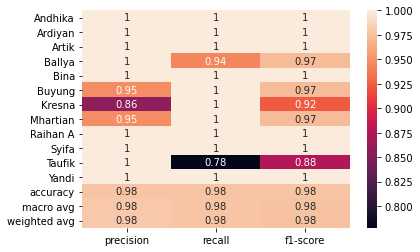

In [155]:
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True)

# ...

In [104]:
kwargs = {
    'input_size' : 64,
    'batch_size' : 32,
    'weights' : 'imagenet',
    'dense' : False
}
nama_model = create_mobilenetv2_name(**kwargs)
print(nama_model)

mobilenetv2_1.00_64-imagenet224-32-12


In [105]:
model = load_full_model(nama_model, True)

weight_filename: 'mobilenetv2_1.00_64-imagenet224-32-12.weights.048_0.9711_0.2074.hdf5'


In [106]:
test_data_gen = create_test_datagen(kwargs['input_size'])

In [107]:
history_dict = model.evaluate(
    test_data_gen,
    batch_size=1,
    verbose=1,
    steps=len(test_data_gen.filenames),
    # callbacks=callbacks,
    # max_queue_size=10,
    # workers=0,
    return_dict=True)

216/216 [==============================] - 29s 133ms/step - loss: 2.2710 - categorical_accuracy: 0.8981 - top-3: 0.9907 - ROC-AUC: 0.9539 - PR-AUC: 0.8515 - precision: 0.8981 - recall: 0.8981 - TP: 194.0000 - TN: 2354.0000 - FP: 22.0000 - FN: 22.0000
